The basis of this is these demand curves generated based on a base model run with no subsidies implemented.

This shows the break-even green H2 price for each sector/technology for select years. Focus on early years for fast change.

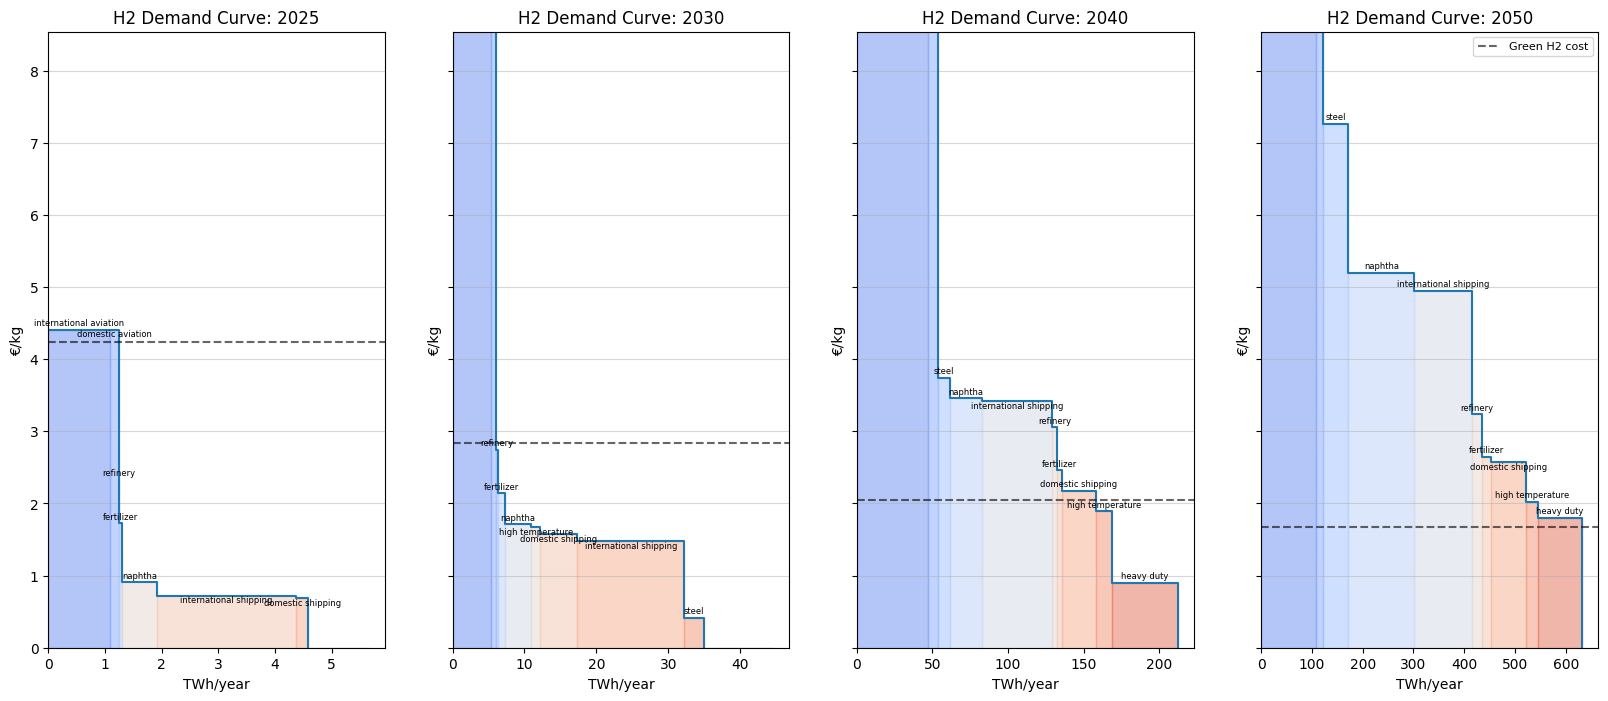

## Initialization

### Preample

In [182]:
import pysd
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#from IPython.parallel import Client
from time import time
from tqdm import tqdm

import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set_palette("colorblind")
sns.set_context("paper", font_scale=1.5)

### Load Vensim model

In [183]:
cwd = os.getcwd()
model_name = "hydrogen_model"
model_short_path = "vensim_models/" + model_name

model_loaded = False # Set to True if the model is loaded from a Python file # Saves some time when reloading an unchanged version of the model

start = time()
if model_loaded: # Load the model from the Python file
    model_file = os.path.join(cwd, model_short_path + ".py")
    model = pysd.load(model_file)
else: # Read the model from the Vensim mdl file
    model_file = os.path.join(cwd, model_short_path + ".mdl")
    model = pysd.read_vensim(model_file, split_views = True)

print("Model loaded in {} seconds".format(np.round(time()-start,3)))

Model loaded in 21.947 seconds


### Load dicts and lists required to easily extract results

In [184]:
from python_scripts.result_loading import result_loading_class

rl = result_loading_class()

### Load input data 

In [185]:
from python_scripts.data_loading import data_loading_class # Import the data_loading_class from the data_loading.py file, which enables easy access to data from the different data sources

### ------- Load new data ------- ###
dl = data_loading_class()
# All data is loaded with function calls to the data_loading_class.
# **kwargs can be used for "sensitivity" : float, which scales the data with a factor

# Fossil fuels:
gas_prices = dl.load_gas_prices()
oil_prices = dl.load_oil_prices()
coal_prices = dl.load_coal_prices()

# Biomass:
woodchip_prices = dl.load_woodchip_prices()
straw_prices = dl.load_straw_prices()
woodpellet_prices = dl.load_woodpellet_prices()

# Electricity:
electricity_prices = dl.load_electricity_prices()

### Setup Base Model

In [186]:
basemodel = model.copy()
final_year = 2050

### ------- Load data in model - if the original model should be saved use model.copy() to copy the current version of the  ------- ###
basemodel.set_components({"GAS PRICE LOOKUP": gas_prices,
                                    "OIL PRICE LOOKUP": oil_prices,
                                    "COAL PRICE LOOKUP": coal_prices,
                                    "BIOMASS PRICE LOOKUP": woodchip_prices,
                                    "CARBON TAX LOOKUP": dl.load_carbon_taxes(),
                                    "Green H2 subsidy size": 0,
                                    "HD BE weight penalty ON": 0}) #, "ELECTRICITY PRICE LOOKUP": electricity_prices})

In [187]:
basemodel_results = basemodel.run(final_time=final_year)

In [188]:
def plot_sector_production(run):
    # Visualize the energy consumption in the different sectors using stacked area plots.
    # Do this in two separate grid plots. One for industry and one for transport. Use the dictionary sector_dict to get the sectors for each category.
    for main_sector in rl.sector_dict.keys():
        fig, axs = plt.subplots(3, 2, figsize=(8, 8))
        fig.suptitle("Technology shares in the " + main_sector + " sectors")
        fig.tight_layout(pad=3.0)  # Add padding between subplots
        for i, (sub_sector, sub_dict) in enumerate(rl.sector_dict[main_sector].items()):
            df = run[sub_dict["stocks"]]
            df.index = run.index
            df.plot.area(ax=axs[i//2, i%2], color=["gray", "blue", "green", "lightblue"])
            axs[i//2, i%2].title.set_text("Evolution in the " + sub_sector + " sector")
            axs[i//2, i%2].title.set_fontsize(8)
            axs[i//2, i%2].set_xlabel("Year")
            axs[i//2, i%2].set_ylabel(sub_dict["unit"])
            # Reduce the font size of the axis labels
            axs[i//2, i%2].xaxis.label.set_fontsize(8)
            axs[i//2, i%2].yaxis.label.set_fontsize(8)
            # Reduce the size of the tick labels
            axs[i//2, i%2].tick_params(axis='both', which='major', labelsize=6)
            # Reduce the size of the legend
            axs[i//2, i%2].legend(loc='lower left', fontsize=6)
            
            axs[i//2, i%2].autoscale(enable=True, axis='both', tight=True)  # Adjust the axis limits to fit the data

        plt.show()

### Sensitivity run functions

MT = 1 milliard kg
10^9 kg * 120 MJ/kg = MJ => MJ / 3600 = MWh => MWh / 10^6 = TWh

In [189]:
def run_subsidies(variables, values, basemodel_sens):
    sens_models = {}
    sens_models["base"] = basemodel
    sens_results = {}
    sens_results["base"] = basemodel_results
    scenarios = []
    for val in tqdm(values, desc="Running subsidy analysis:"):
        name =  " &\n".join(variables) + " = " + str(val)
        scenarios.append(name)
        sens_models[name] = basemodel_sens.copy()
        sens_models[name].set_components({variable: val for variable in variables}) 
        sens_results[name] = sens_models[name].run(final_time=final_year)
    return sens_results, sens_models, scenarios

In [190]:
# Function for plotting results of a parameter for different scenarios
def plot_sens_results(sens_results : dict, parameters : list):
    fig, axs = plt.subplots(1, len(parameters), figsize = (5 * len(parameters), 5))
    for ix in range(len(parameters)):
        parameter = parameters[ix][0]
        unit = parameters[ix][1]
        scaler = 1
        if unit == "tH2":
            scaler = 120 / 3600 / 1e3
            unit = "TWh"
        if unit == "M€":
            scaler = 1e-3
            unit = "B€"
        for i in sens_results:
            axs[ix].plot(sens_results[i][parameter]*scaler, label = i)
        axs[ix].legend(fontsize=6)
        axs[ix].set_title(parameter)
        axs[ix].set_xlabel("Year")
        axs[ix].set_ylabel(unit)
        axs[ix].set_xlim(2022, final_year)
        axs[ix].set_ylim(0)
        axs[ix].grid(alpha=0.5)
    plt.show()

In [191]:
def co2_efficiency_plotter(sens_results, scenarios):
    # Calculate the subsidy cost per tCO2 saved
    fig, ax = plt.subplots(figsize=(6,4))
    subsidy_cost_per_tCO2 = {}
    for i in scenarios:
        subsidy_cost_per_tCO2[i] = sens_results[i]["TOTAL SUBSIDIES"].iloc[-1] / (np.sum(sens_results["base"]["TOTAL EMISSIONS"]) - np.sum(sens_results[i]["TOTAL EMISSIONS"]))
    plt.bar(subsidy_cost_per_tCO2.keys(),np.array(list(subsidy_cost_per_tCO2.values()))*10**6)
    plt.title("Subsidy cost per tCO2 avoided")
    plt.xticks(rotation=90)
    plt.xlabel("Scenario")
    plt.ylabel("[€/(tCO2)]")
    plt.grid(axis='y')

## Subsidy Runs

**Variables/objects of interest from initialization:**

basemodel: Object which represents the model which can be copied, modified, and run.

basemodel_results: DataFrame with base model results without subsidies.

rl: result_loader Object with lists and dicts used to extract results from basemodel_results or other runs.

#### Different sizes of subsidies:

In [149]:
subsidy_sizes = [1, 2, 3]
subsize_results, subsize_models, subsize_scenarios = run_subsidies(["Green H2 subsidy size"], subsidy_sizes, basemodel)

Running subsidy analysis:: 100%|██████████| 3/3 [00:46<00:00, 15.54s/it]


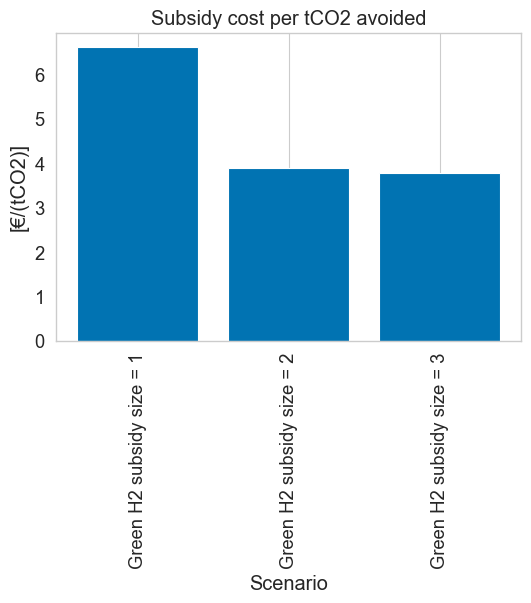

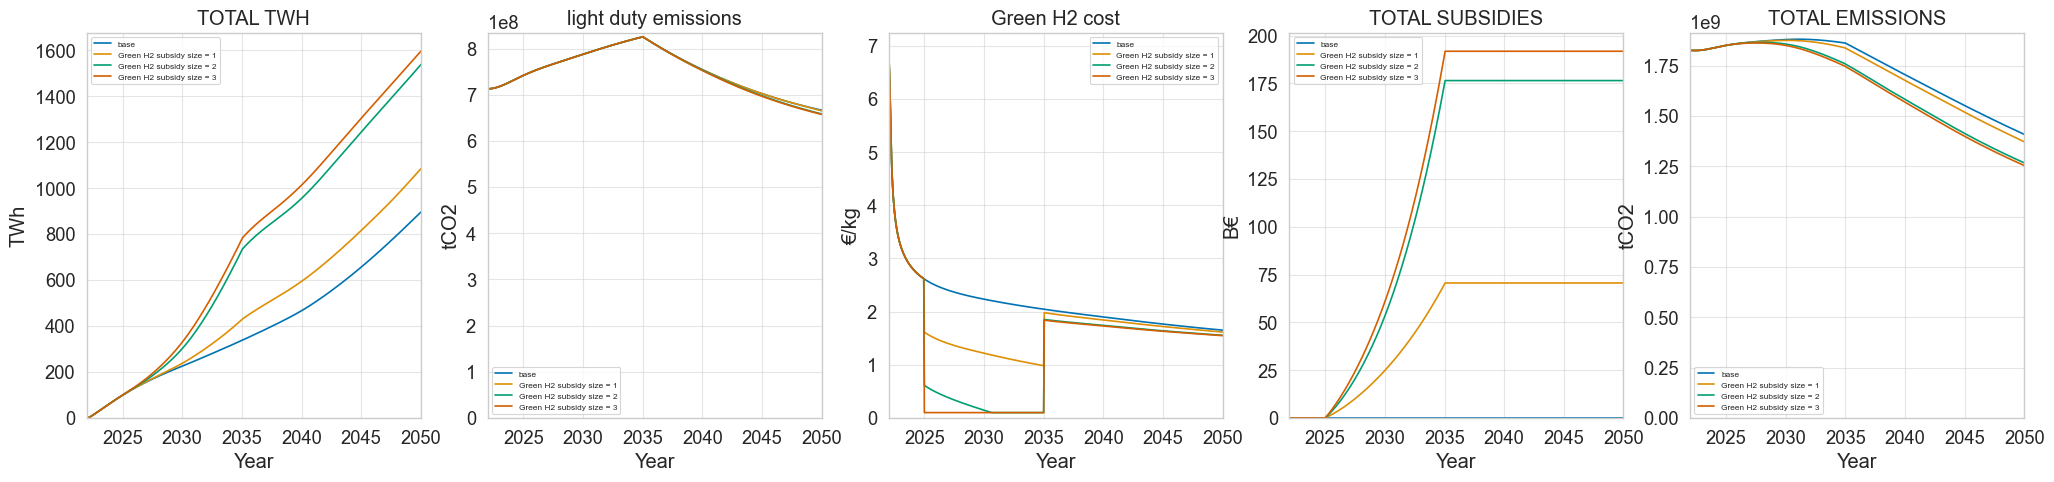

In [150]:
stocks = ["TOTAL TWH", "light duty emissions", "Green H2 cost", "TOTAL SUBSIDIES", "TOTAL EMISSIONS"]
units = ["TWh", "tCO2", "€/kg", "M€", "tCO2"]
params = [(stocks[i], units[i]) for i in range(len(units))]

co2_efficiency_plotter(subsize_results, subsize_scenarios)
plot_sens_results(subsize_results, params)

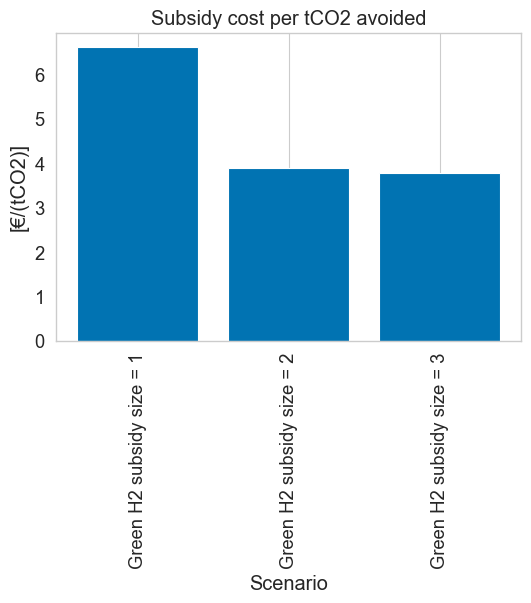

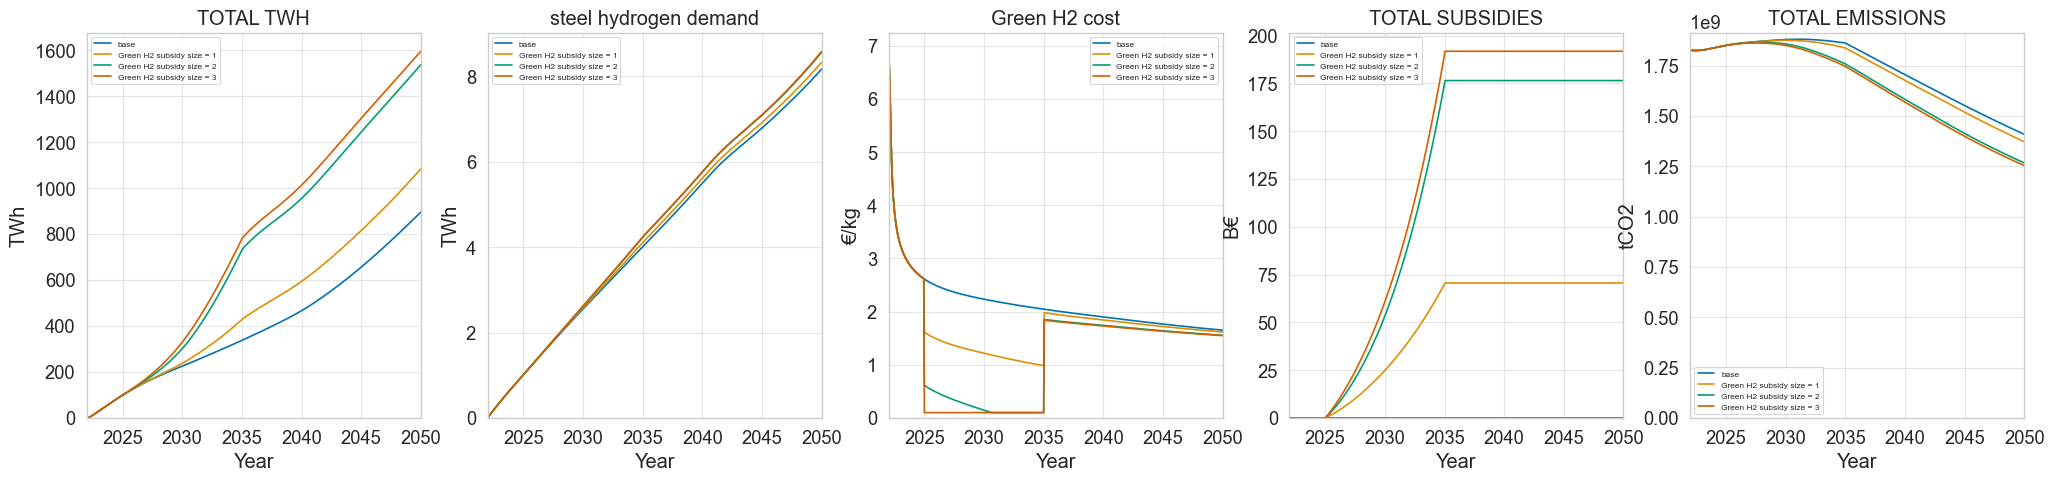

In [151]:
stocks = ["TOTAL TWH", "steel hydrogen demand", "Green H2 cost", "TOTAL SUBSIDIES", "TOTAL EMISSIONS"]
units = ["TWh", "tH2", "€/kg", "M€", "tCO2"]
params = [(stocks[i], units[i]) for i in range(len(units))]

plot_sens_results(subsize_results, params)

#### Different length of subsidies

In [152]:
subsidy_length_model = basemodel.copy()
subsidy_length_model.set_components({"Green H2 subsidy size": 2})

subsidy_lengths = [5, 10, 15, 20, 25] # years
sublen_results, sublen_models, sublen_scenarios = run_subsidies(["H2 subsidy length"], subsidy_lengths, subsidy_length_model)

Running subsidy analysis:: 100%|██████████| 5/5 [00:55<00:00, 11.14s/it]


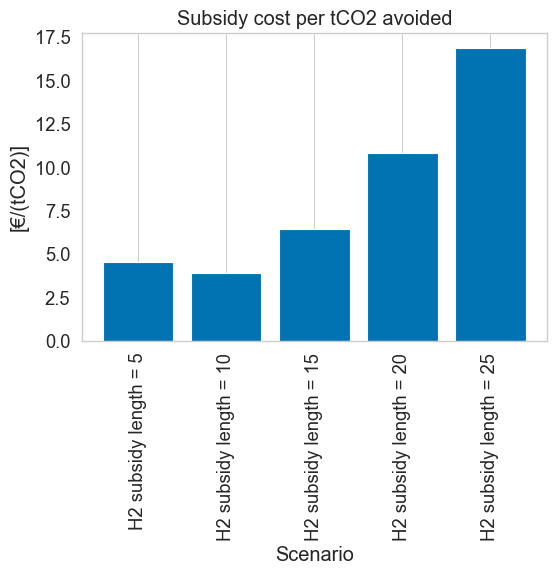

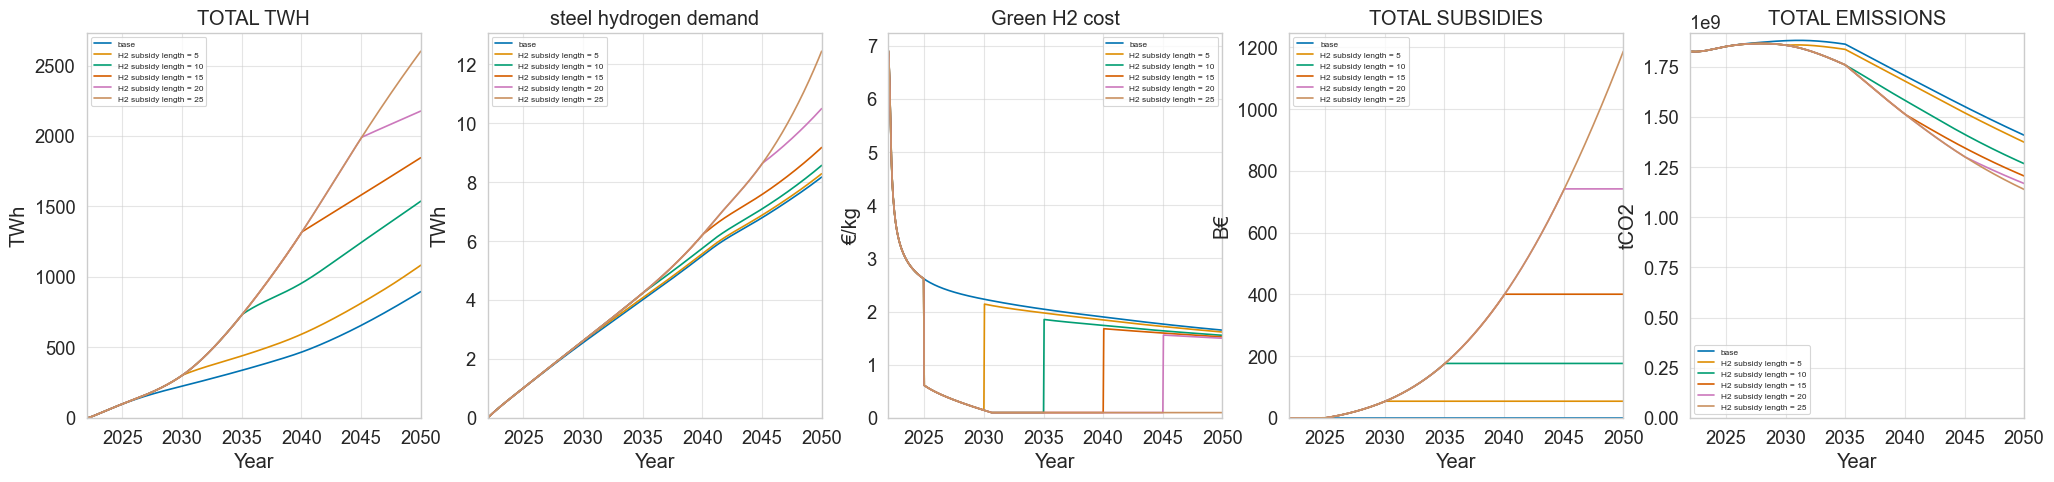

In [153]:
co2_efficiency_plotter(sublen_results, sublen_scenarios)
plot_sens_results(sublen_results, params)

### Subsidizing specific sectors

#### Oil Refining and Fertilizers

In [154]:
subsidy_sizes = [0.5, 1, 1.5, 2, 2.5, 3]
subsize_fertil_results, subsize_fertil_models, subsize_fertil_scenarios = run_subsidies(["fertilizer H2 subsidy size"], subsidy_sizes, basemodel)
subsize_refine_results, subsize_refine_models, subsize_refine_scenarios = run_subsidies(["refinery H2 subsidy size"], subsidy_sizes, basemodel)
subsize_direct_results, subsize_direct_models, subsize_direct_scenarios = run_subsidies(["refinery H2 subsidy size", "fertilizer H2 subsidy size"], subsidy_sizes, basemodel)

Running subsidy analysis:: 100%|██████████| 6/6 [01:10<00:00, 11.67s/it]


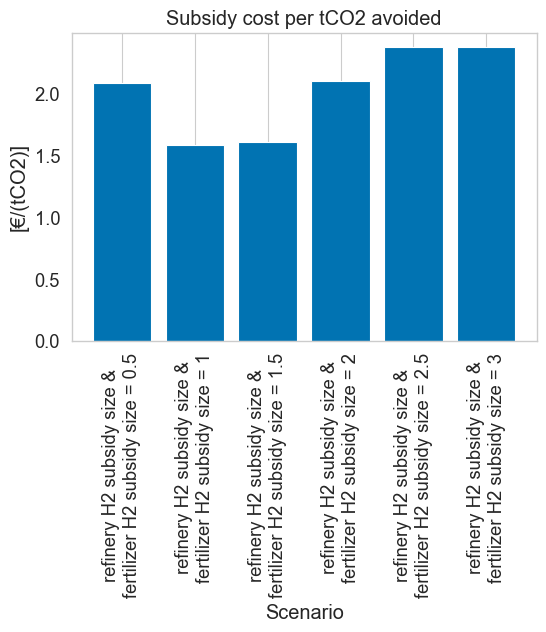

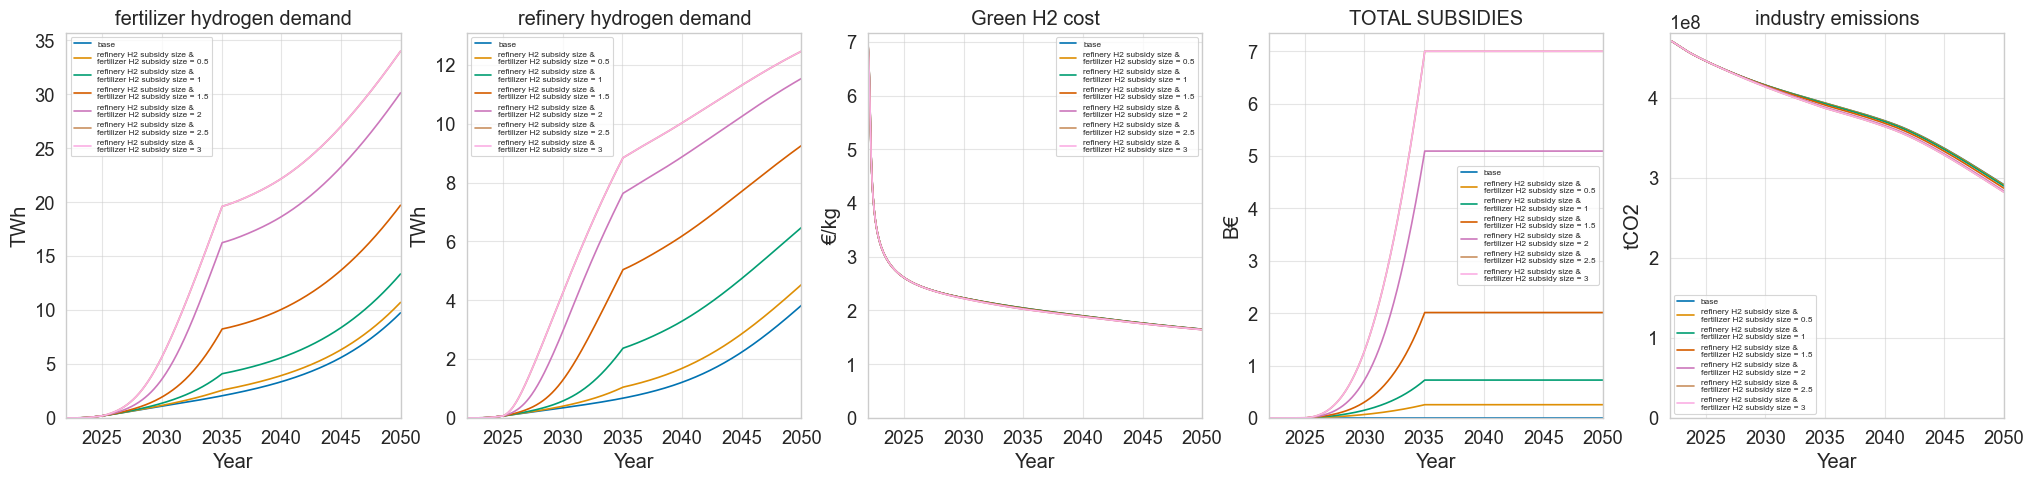

In [155]:
stocks = ["fertilizer hydrogen demand", "refinery hydrogen demand", "Green H2 cost", "TOTAL SUBSIDIES", "industry emissions", ]#"transportation emissions"]
units = ["tH2", "tH2", "€/kg", "M€", "tCO2", ]#"tCO2"]
params = [(stocks[i], units[i]) for i in range(len(units))]

co2_efficiency_plotter(subsize_direct_results, subsize_direct_scenarios)
plot_sens_results(subsize_direct_results, params)

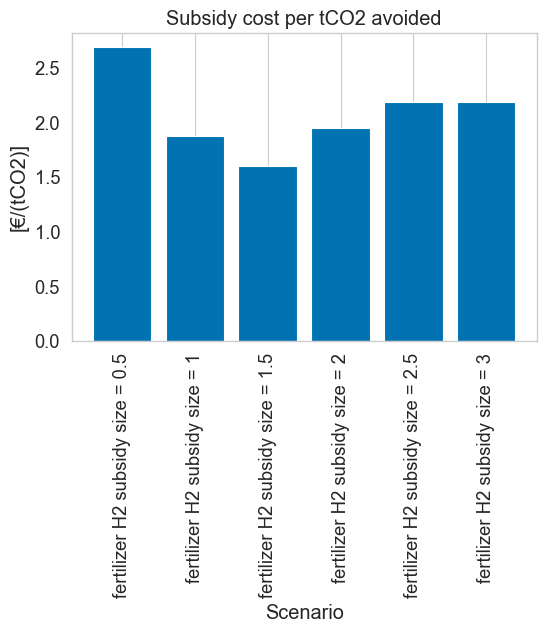

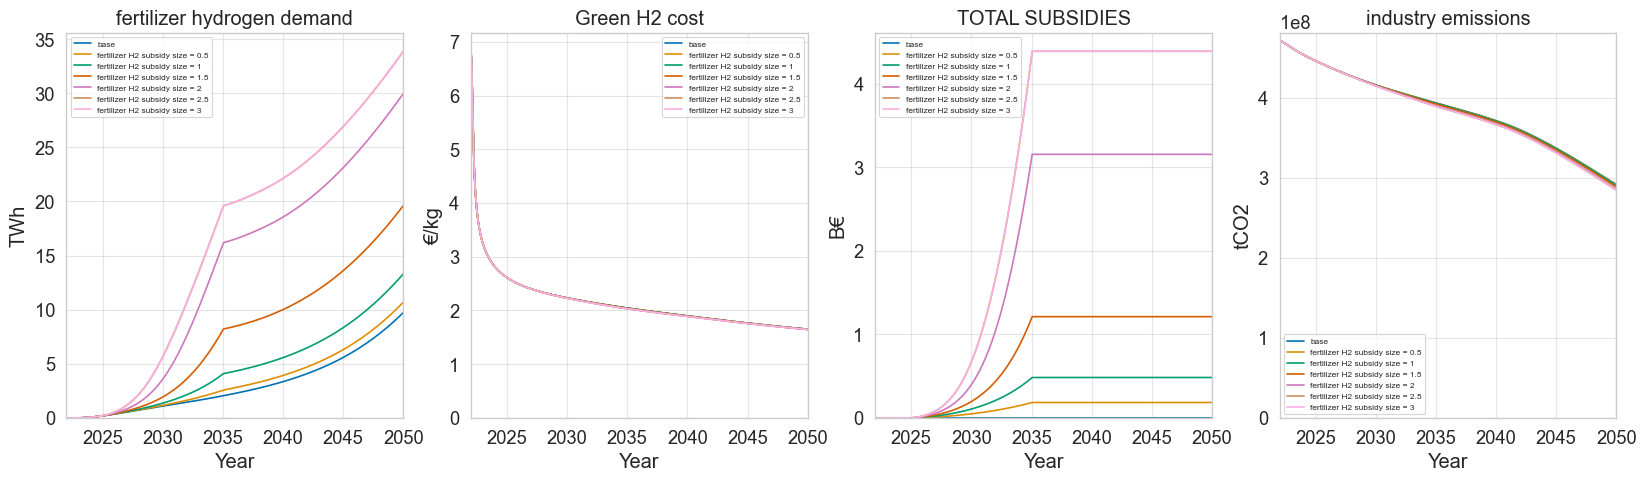

In [156]:
# Subsidizing ammonia production for fertilizer
stocks = ["fertilizer hydrogen demand", "Green H2 cost", "TOTAL SUBSIDIES", "industry emissions", ]#"transportation emissions"]
units = ["tH2", "€/kg", "M€", "tCO2", ]#"tCO2"]
params = [(stocks[i], units[i]) for i in range(len(units))]

co2_efficiency_plotter(subsize_fertil_results, subsize_fertil_scenarios)
plot_sens_results(subsize_fertil_results, params)

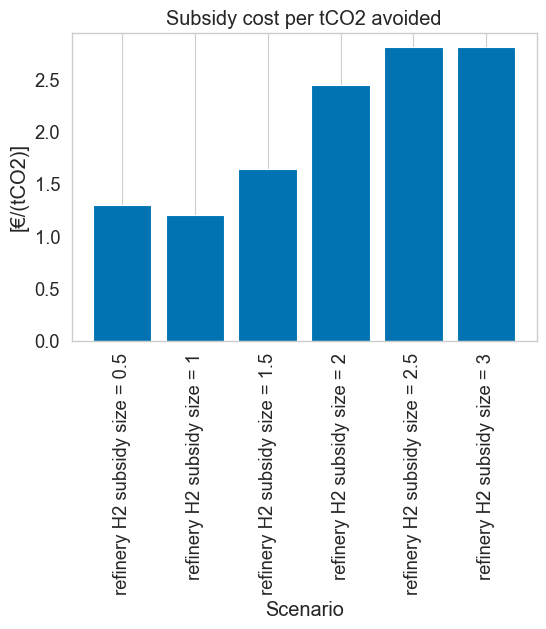

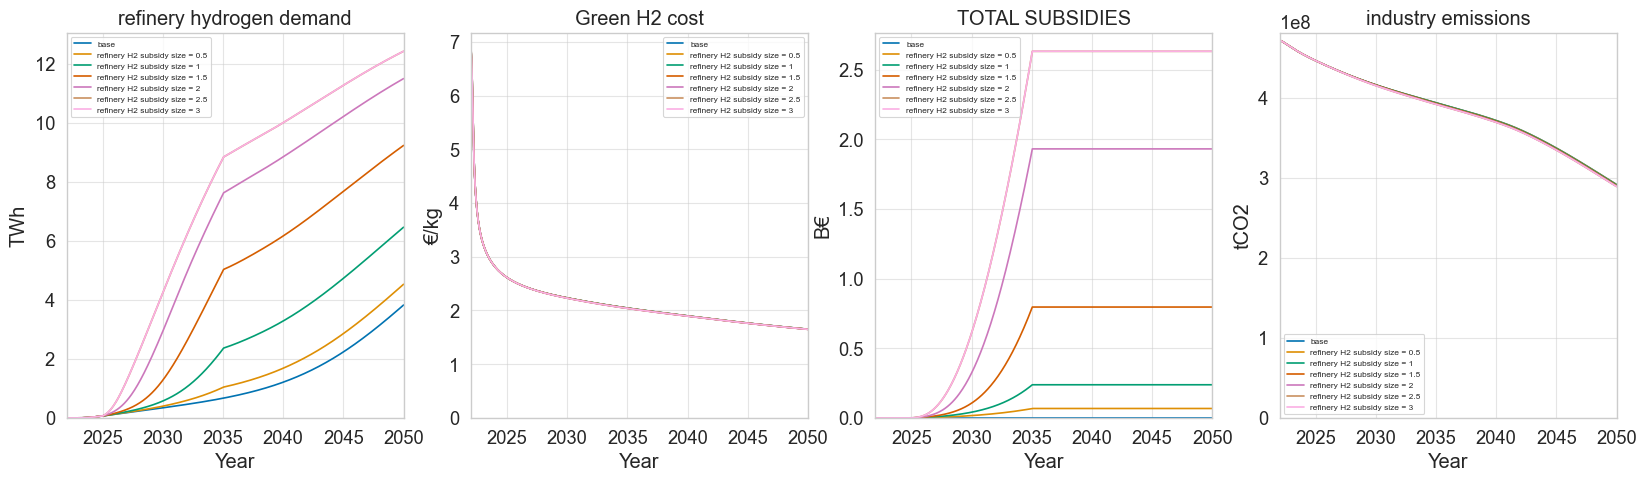

In [157]:
# Subsidizing refinery green H2 production
stocks = ["refinery hydrogen demand", "Green H2 cost", "TOTAL SUBSIDIES", "industry emissions", ]#"transportation emissions"]
units = ["tH2", "€/kg", "M€", "tCO2", ]#"tCO2"]
params = [(stocks[i], units[i]) for i in range(len(units))]

co2_efficiency_plotter(subsize_refine_results, subsize_refine_scenarios)
plot_sens_results(subsize_refine_results, params)

#### H2 for synthetic/biogenic Fischer-Tropsch fuels

Subsidizing green H2 for FT-fuels: Synthetic Kerosene and Naphtha, Biogenic Kerosene and Naphtha.

In [158]:
subsidy_sizes = [0.5, 1, 1.5, 2, 2.5, 3]
subsize_FT_results, subsize_FT_models, subsize_FT_scenarios = run_subsidies(["FT H2 subsidy size"], subsidy_sizes, basemodel)

Running subsidy analysis:: 100%|██████████| 6/6 [01:09<00:00, 11.60s/it]


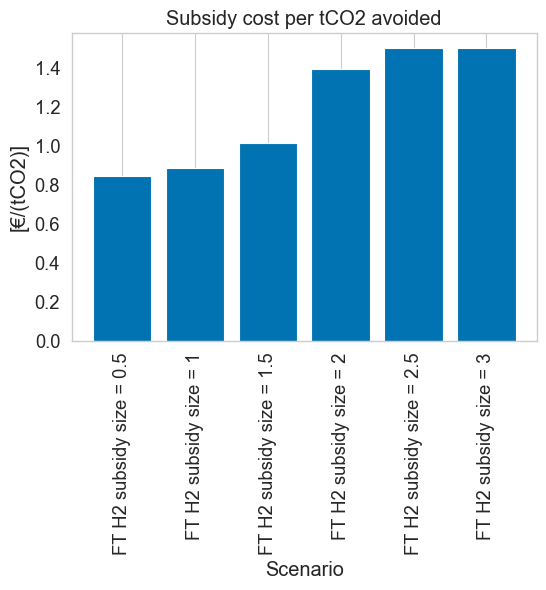

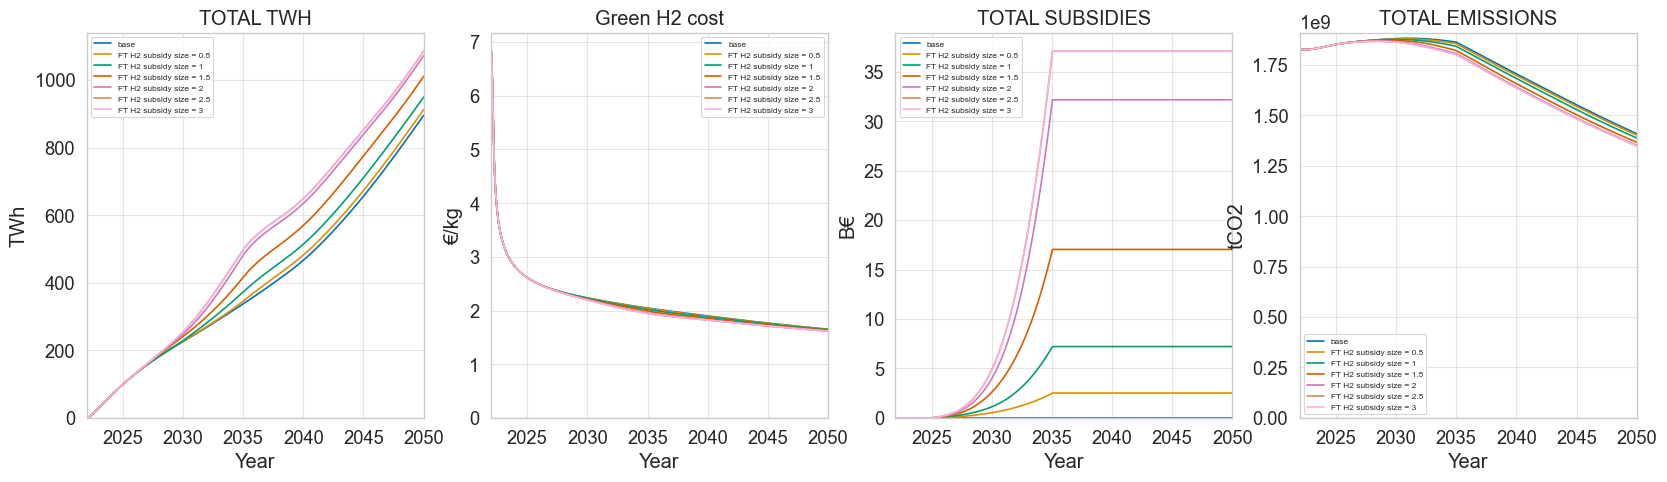

In [160]:
stocks = ["TOTAL TWH", "Green H2 cost", "TOTAL SUBSIDIES", "TOTAL EMISSIONS wo LD"]
units = ["TWh", "€/kg", "M€", "tCO2"]
params = [(stocks[i], units[i]) for i in range(len(units))]

co2_efficiency_plotter(subsize_FT_results, subsize_FT_scenarios)
plot_sens_results(subsize_FT_results, params)

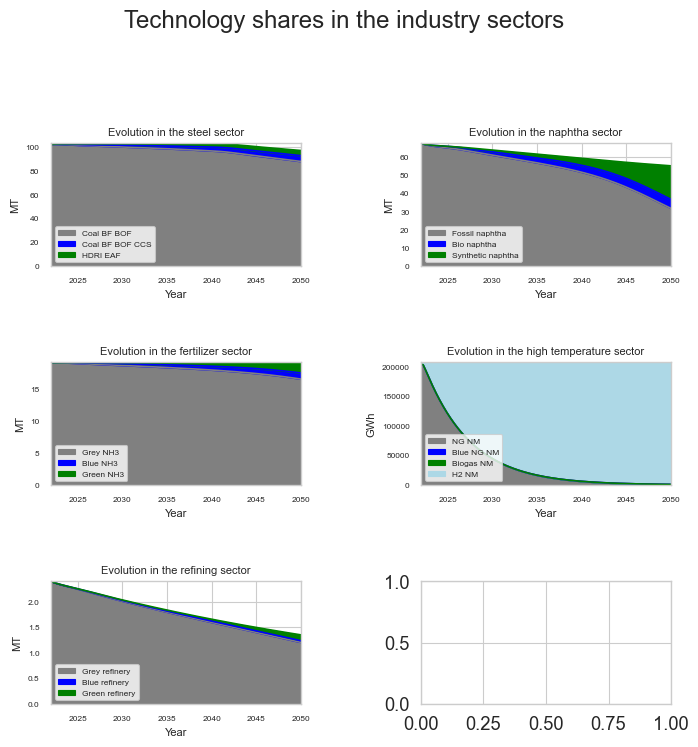

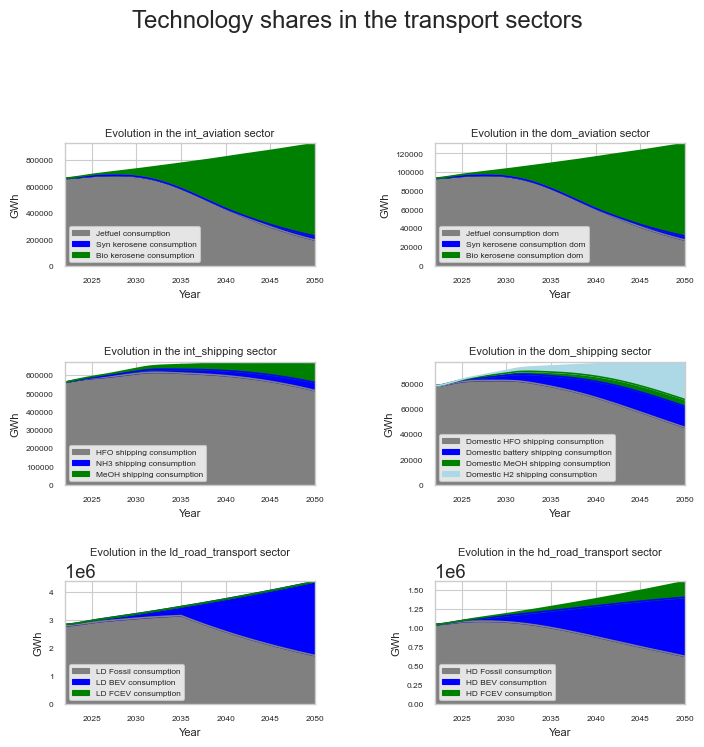

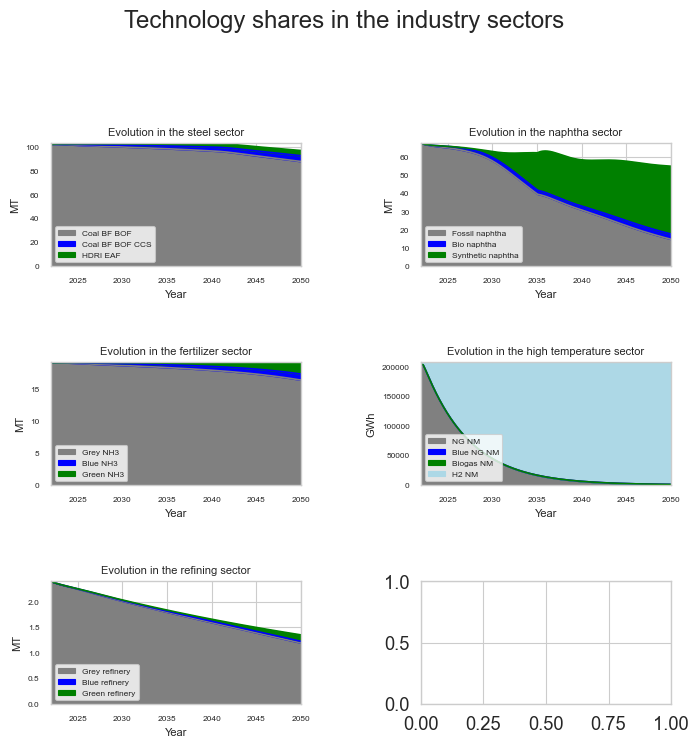

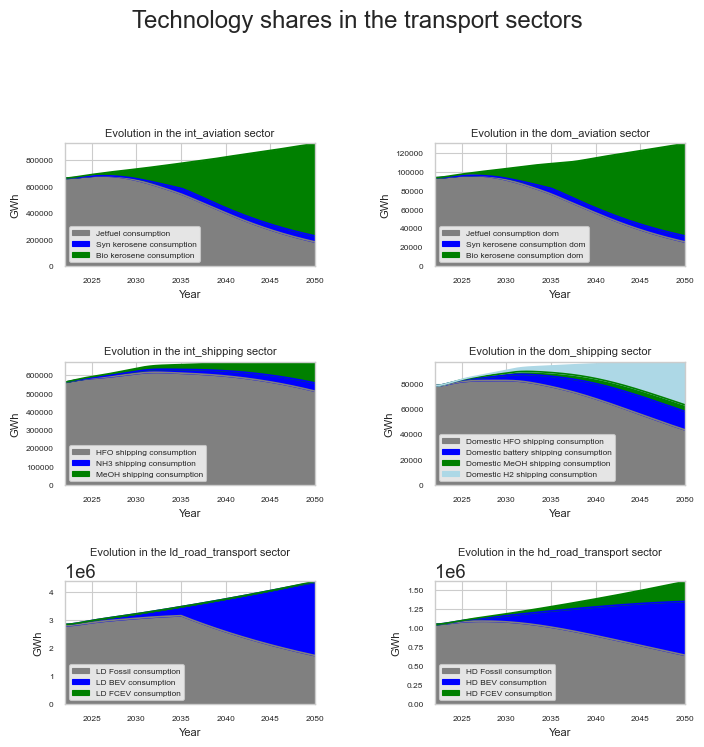

In [161]:
plot_sector_production(basemodel_results)
plot_sector_production(subsize_FT_results["FT H2 subsidy size = 3"])

#### Steel and MeOH with endogenous learning rates.

In [162]:
subsidy_sizes = [2, 5, 10]
subsize_endo_lr_results, subsize_endo_lr_models, subsize_endo_lr_scenarios = run_subsidies(["steel H2 subsidy size", "shipping MeOH H2 subsidy size"], subsidy_sizes, basemodel)

Running subsidy analysis:: 100%|██████████| 3/3 [00:37<00:00, 12.44s/it]


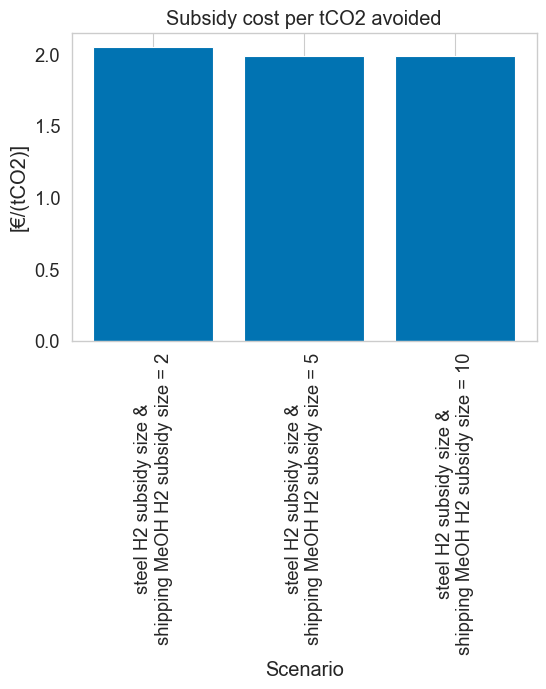

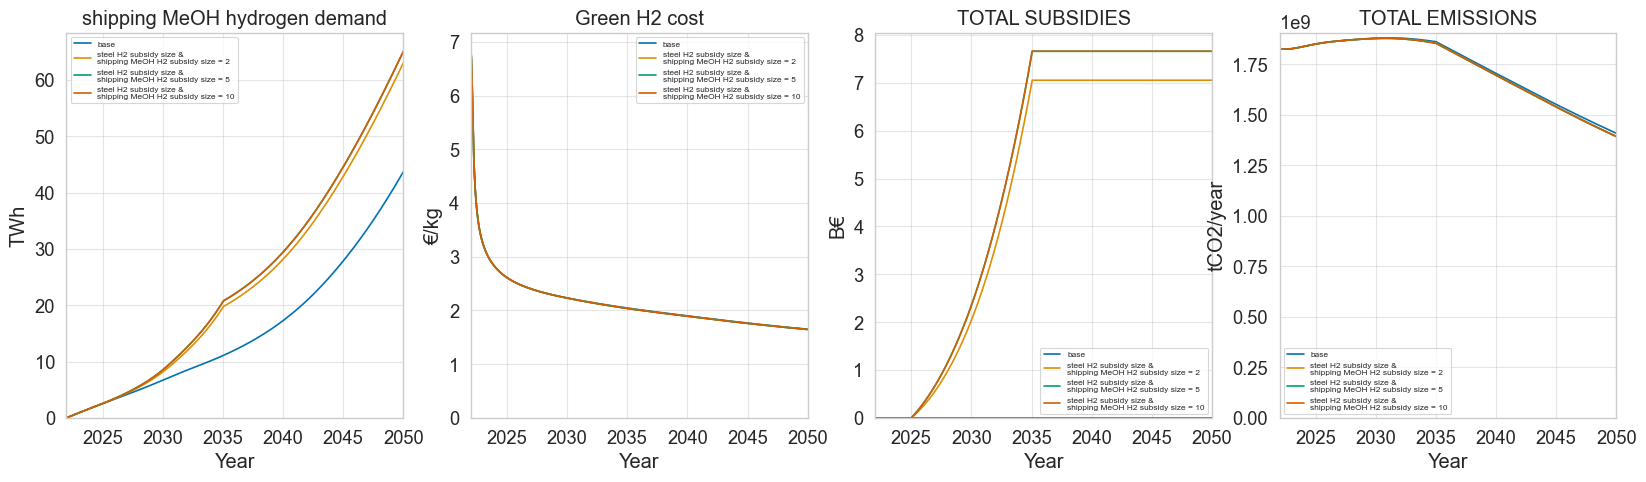

In [163]:
stocks = ["shipping MeOH hydrogen demand", "Green H2 cost", "TOTAL SUBSIDIES", "TOTAL EMISSIONS"]
units = ["tH2", "€/kg", "M€", "tCO2/year"]
params = [(stocks[i], units[i]) for i in range(len(units))]

co2_efficiency_plotter(subsize_endo_lr_results, subsize_endo_lr_scenarios)
plot_sens_results(subsize_endo_lr_results, params)

#### Shipping

In [164]:
subsidy_sizes = [0.5, 1, 1.5, 2, 2.5, 3]
subsize_shipping_results, subsize_shipping_models, subsize_shipping_scenarios = run_subsidies(["shipping NH3 H2 subsidy size", "shipping MeOH H2 subsidy size"], subsidy_sizes, basemodel)

Running subsidy analysis:: 100%|██████████| 6/6 [01:11<00:00, 12.00s/it]


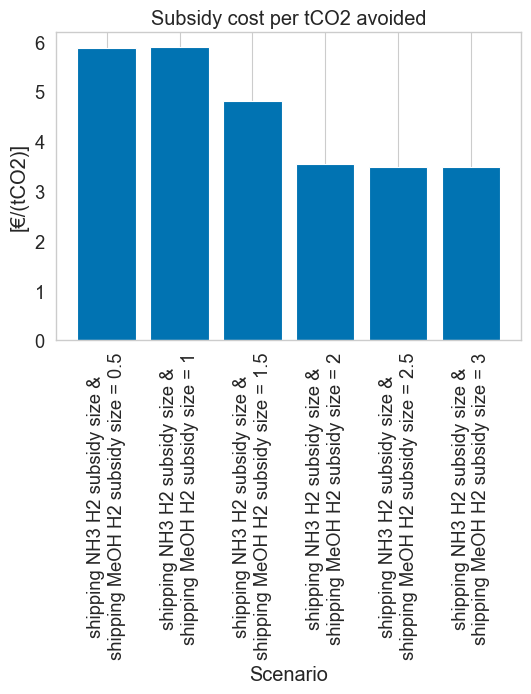

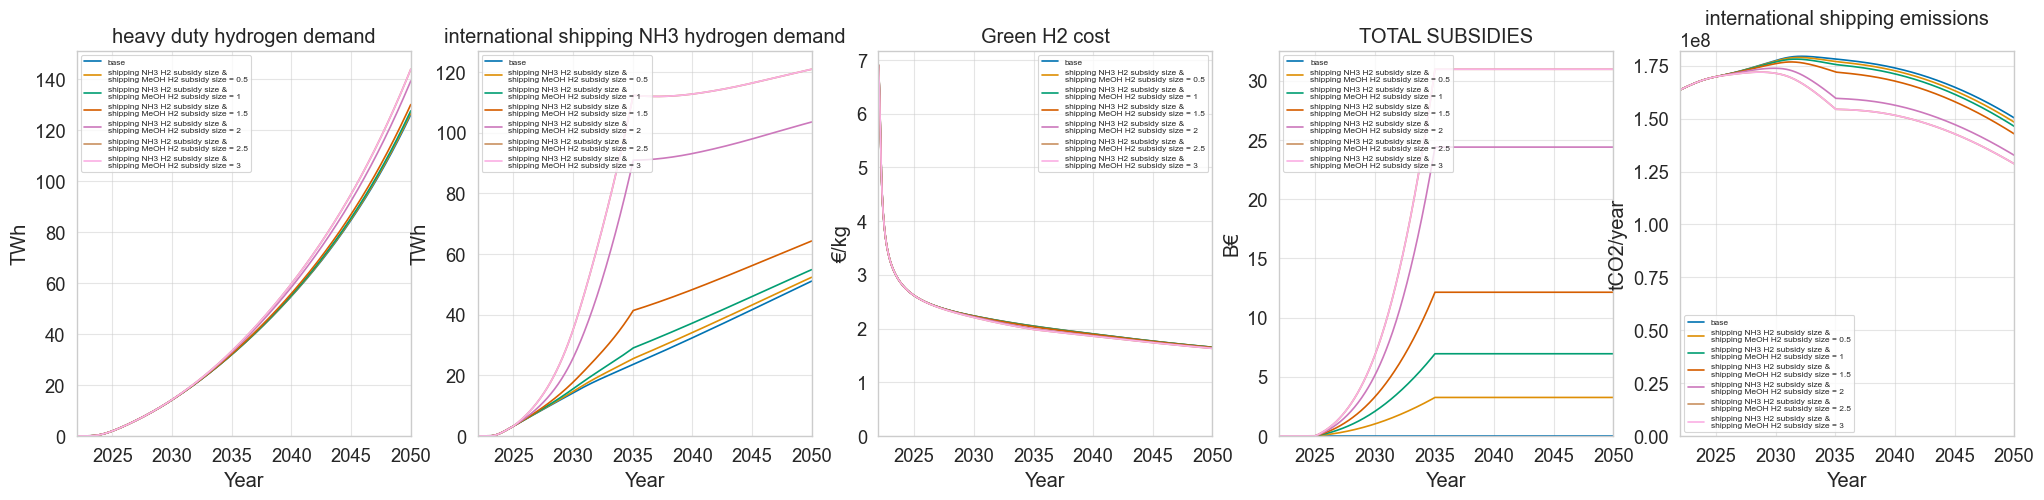

In [165]:
stocks = ["heavy duty hydrogen demand", "international shipping NH3 hydrogen demand", "Green H2 cost", "TOTAL SUBSIDIES", "international shipping emissions"]
units = ["tH2", "tH2", "€/kg", "M€", "tCO2/year"]
params = [(stocks[i], units[i]) for i in range(len(units))]

co2_efficiency_plotter(subsize_shipping_results, subsize_shipping_scenarios)
plot_sens_results(subsize_shipping_results, params)

In [169]:
subsidy_sizes = [1, 1.5, 2, 3]
subsize_shipping_NH3_results, subsize_shipping_NH3_models, subsize_shipping_NH3_scenarios = run_subsidies(["shipping NH3 H2 subsidy size"], subsidy_sizes, basemodel)

Running subsidy analysis:: 100%|██████████| 4/4 [00:53<00:00, 13.43s/it]


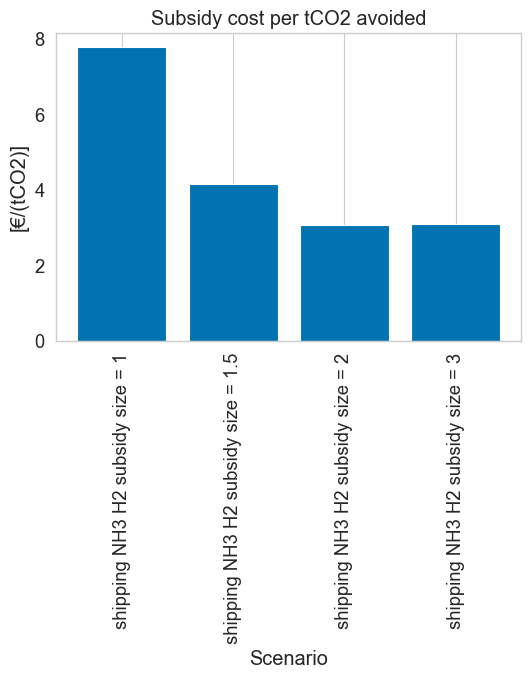

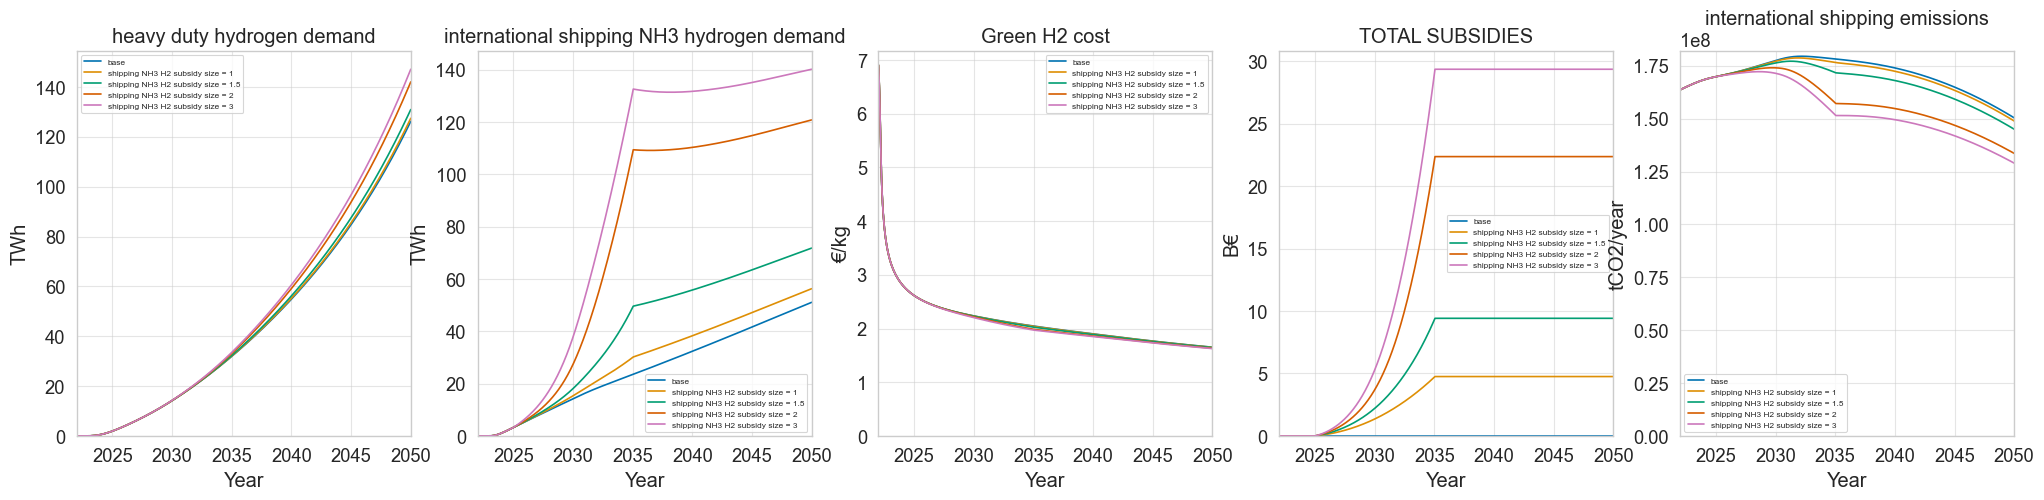

In [170]:
stocks = ["heavy duty hydrogen demand", "international shipping NH3 hydrogen demand", "Green H2 cost", "TOTAL SUBSIDIES", "international shipping emissions"]
units = ["tH2", "tH2", "€/kg", "M€", "tCO2/year"]
params = [(stocks[i], units[i]) for i in range(len(units))]

co2_efficiency_plotter(subsize_shipping_NH3_results, subsize_shipping_NH3_scenarios)
plot_sens_results(subsize_shipping_NH3_results, params)

#### Heavy duty road transport

In [166]:
subsidy_sizes = [1, 2, 3]
subsize_hd_results, subsize_hd_models, subsize_hd_scenarios = run_subsidies(["HD H2 subsidy size"], subsidy_sizes, basemodel)

Running subsidy analysis:: 100%|██████████| 3/3 [00:35<00:00, 11.88s/it]


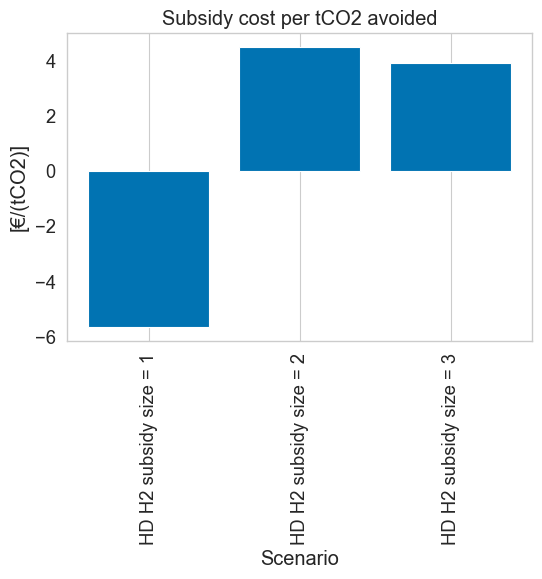

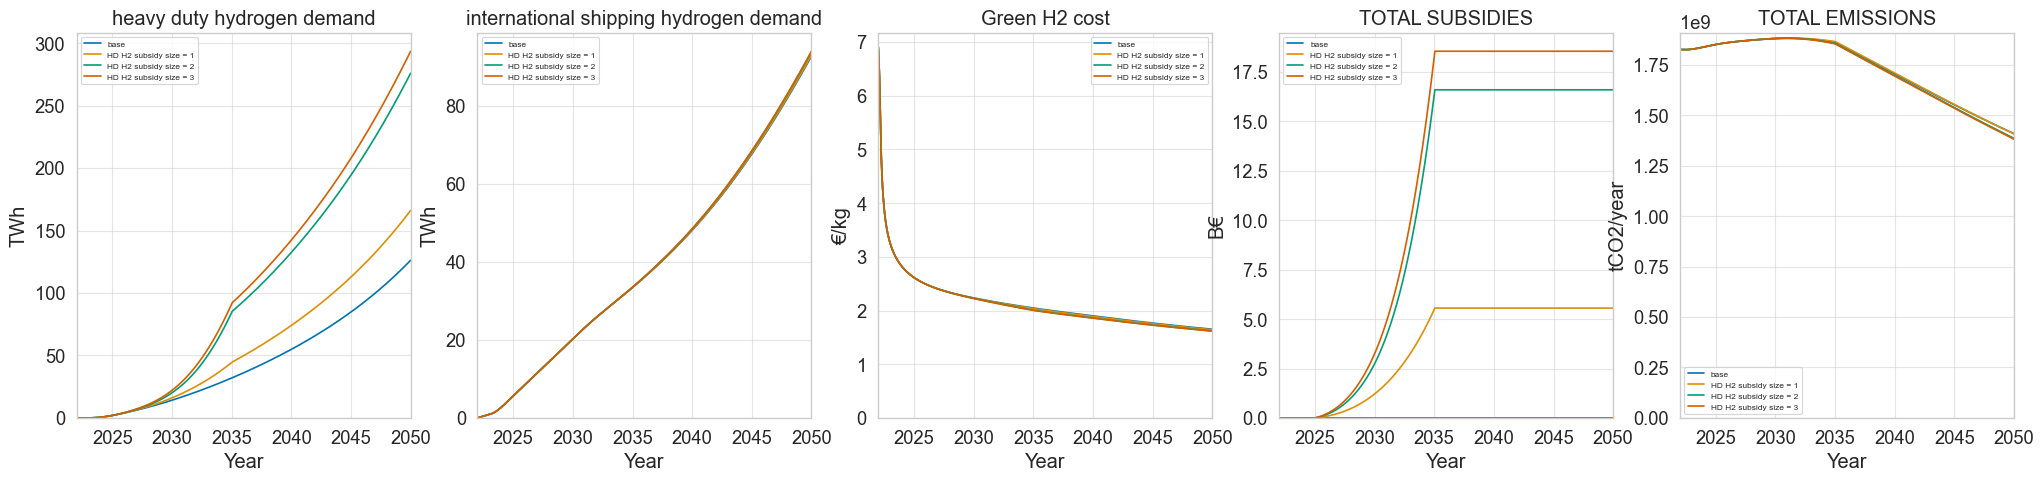

In [167]:
stocks = ["heavy duty hydrogen demand", "international shipping hydrogen demand", "Green H2 cost", "TOTAL SUBSIDIES", "TOTAL EMISSIONS"]
units = ["tH2", "tH2", "€/kg", "M€", "tCO2/year"]
params = [(stocks[i], units[i]) for i in range(len(units))]

co2_efficiency_plotter(subsize_hd_results, subsize_hd_scenarios)
plot_sens_results(subsize_hd_results, params)

#### H2 Steel CAPEX

In [202]:
subsidy_sizes = [0.1, 0.5, 1]
subsize_capex_results, subsize_capex_models, subsize_capex_scenarios = run_subsidies(["HDRI CAPEX subsidy size"], subsidy_sizes, basemodel)

Running subsidy analysis:: 100%|██████████| 3/3 [00:42<00:00, 14.22s/it]


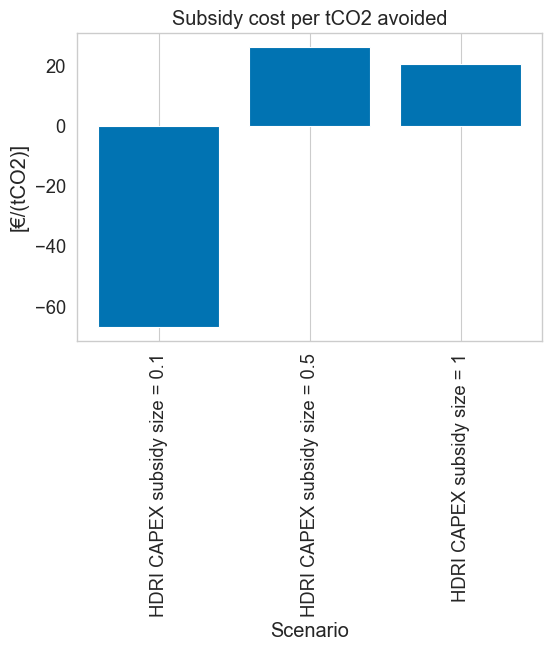

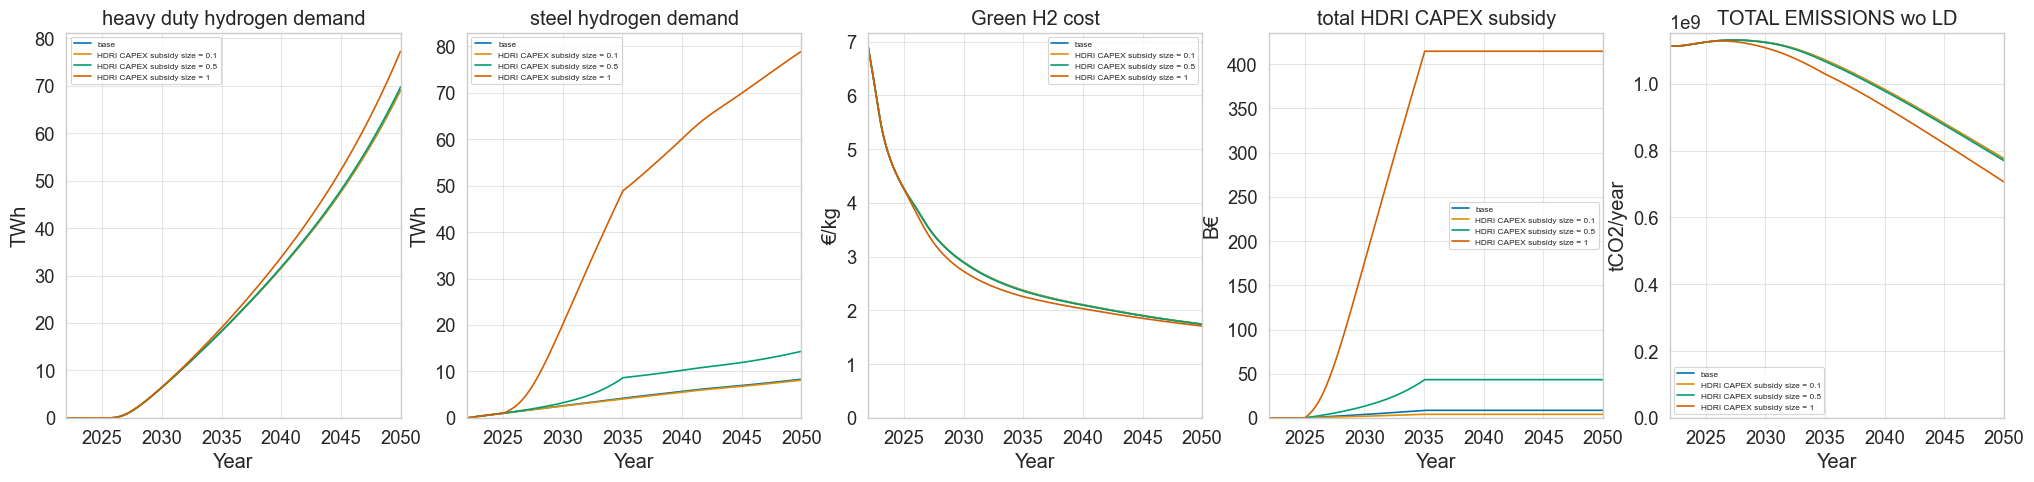

In [205]:
stocks = ["heavy duty hydrogen demand", "steel hydrogen demand", "Green H2 cost", "total HDRI CAPEX subsidy", "TOTAL EMISSIONS wo LD"]
units = ["tH2", "tH2", "€/kg", "M€", "tCO2/year"]
params = [(stocks[i], units[i]) for i in range(len(units))]

# Calculate the subsidy cost per tCO2 saved
fig, ax = plt.subplots(figsize=(6,4))
subsidy_cost_per_tCO2 = {}
for i in subsize_capex_scenarios:
    subsidy_cost_per_tCO2[i] = subsize_capex_results[i]["total HDRI CAPEX subsidy"].iloc[-1] / (np.sum(subsize_capex_results["base"]["TOTAL EMISSIONS"]) - np.sum(subsize_capex_results[i]["TOTAL EMISSIONS"]))
plt.bar(subsidy_cost_per_tCO2.keys(),np.array(list(subsidy_cost_per_tCO2.values()))*10**6)
plt.title("Subsidy cost per tCO2 avoided")
plt.xticks(rotation=90)
plt.xlabel("Scenario")
plt.ylabel("[€/(tCO2)]")
plt.grid(axis='y')

plot_sens_results(subsize_capex_results, params)

## End of Notebook